In [2]:
## imports

import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import genfromtxt
import pandas as pd
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForMaskedLM
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.utils.data import DataLoader    
import torchvision.utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import random
# from pytorch_lightning.core.lightning import LightningModule
# from pytorch_lightning import Trainer
# import pytorch_lightning as pl
# from ray_lightning import RayPlugin, RayShardedPlugin
import ray
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
import os
import re
import requests
from tqdm.auto import tqdm
import pickle as pk
import time
import utils
from sklearn.decomposition import PCA
import math
from pprint import pprint
import shap
from captum.attr import IntegratedGradients
import seaborn as sns
import matplotlib.pyplot as plt

import nltk, sklearn
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 1.0.2.


In [2]:
## classes
class SiameseNetwork(torch.nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding, use_irm=False, n_hidden_node=32, struct_code=0):
        '''
            struct_code {0=simple, 1=comple} structure
        '''
        
        super(SiameseNetwork, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.use_irm = use_irm
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.n_hidden_node = n_hidden_node
        #-----------change_1
        if struct_code == 0:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.abstract_len_embedding),
            )
        elif struct_code == 1:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),            
                nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.2),
                nn.Linear(int(self.n_hidden_node/4), self.abstract_len_embedding),
            )
        else:
            self.nn_reg = nn.Sequential(
                nn.Linear(self.len_embedding, self.abstract_len_embedding),
            )            
        #-----------change_1
        self.nn_final_reg = nn.Sequential(
            nn.Linear(self.abstract_len_embedding * 2, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),
            nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.2),
            nn.Linear(int(self.n_hidden_node/4), 1),
        )

    def forward_reg(self, x):
        output = self.nn_reg(x)
        return output

    def forward_final_reg(self, x):
        output = self.nn_final_reg(x)
        return output

    def forward(self, fp1, fp2):
        a = self.forward_reg(fp1)
        b = self.forward_reg(fp2)
        x = torch.cat([a, b], dim=1)  # hstack
        output = self.forward_final_reg(x)
        return output

    def compute_penalty(self, losses, dummy_w):
        g = grad(losses, dummy_w, create_graph=True)[0]
        r = g.pow(2)
        return r     

In [4]:
trial_no = 2
env_no = 1
# for trial_no in range(1,2):
#     for env_no in range(4):
curdir = '' # '/curdir/'
dir_datasets = curdir + 'datasets/'
data = genfromtxt(dir_datasets + 'filtered_embedding_vs_energy_env_' + str(env_no) + '.csv', delimiter=',', dtype='float32')
feature = data[:, 0:-1]
target = data[:, [-1]]

print(feature.shape, target.shape)

pca_n_components = 6 ## this was for trial 0 and env no 1 (check logger)
print(pca_n_components)

_nhn, _lr, _sc = 128, "('0.01',)", 1 

# Initialize the model
model_siamese = SiameseNetwork(int(feature.shape[1]), pca_n_components, n_hidden_node=_nhn, struct_code=_sc)
model_path = curdir + 'datasets/best_model_' + str(trial_no) + '_' + str(env_no) + '_' + str(_nhn) + '_' + str(_lr) + '_' + str(_sc) + '.pt'
# Load the model's parameters
model_siamese.load_state_dict(torch.load(model_path))
model_siamese.eval()  # Set the model to evaluation mode

model_name = 'Siamese'            
feature_siamese, target_siamese = model_siamese.forward_reg(torch.from_numpy(feature)).detach().numpy(), target 
X_train, X_test, y_train, y_test = train_test_split(
    feature_siamese, target_siamese, test_size=0.33, random_state=trial_no+10
)    
trainX, testX, trainY, testY = X_train, X_test, y_train.ravel(), y_test.ravel()

print(trainX.shape, testX.shape, trainY.shape, testY.shape)

# Define the alphas for RidgeCV
alphas = [0.001, 0.01, 0.1, 1.0]

# Train Ridge regressor using cross-validation
ridge_regressor = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_regressor.fit(trainX, trainY)

# Predict using the trained Ridge regressor
predY = ridge_regressor.predict(testX)
errors = np.absolute(predY - testY)
error = np.mean(errors)

print("Optimal alpha:", ridge_regressor.alpha_)
print(trial_no, env_no, 'Error:', error)


(46, 24) (46, 1)
6
(30, 6) (16, 6) (30,) (16,)
Optimal alpha: 1.0
2 1 Error: 0.09711493921805453


In [5]:
#################################################

In [6]:
# 1. Compute the attributions of the 24 features to each of the 7-length transformed feature
ig = IntegratedGradients(model_siamese.forward_reg)
# Initialize an array to store separate attributions for each of the 7 outputs
attributions_array = np.zeros((feature.shape[0], feature.shape[1], 6))  # Shape: (45, 24, 7)
# Compute attributions for each output unit in the 7-length feature
for i in range(6):
    attributions = ig.attribute(torch.tensor(feature).float(), target=i)
    attributions_array[:,:,i] = attributions.numpy()
print(attributions_array.shape)

(46, 24, 6)


In [7]:
# 2. Contribution of the 7-length transformed feature to the final target
ridge_contributions = ridge_regressor.coef_  # Shape: (7,)
# print(ridge_contributions)
print(ridge_contributions.shape)

(6,)


In [8]:
ridge_contributions

array([ 0.01421294, -0.01358025,  0.19374021,  0.01091132, -0.0737291 ,
        0.03168057])

In [9]:
# 3. Multiply the attributions for each of the 7 outputs with their corresponding ridge coefficients
final_attributions = np.tensordot(attributions_array, ridge_contributions, axes=([2], [0]))  # Shape: (45, 24)
print(final_attributions.shape)

(46, 24)


In [3]:
df = pd.read_csv('datasets/smiles_vs_energy_env_0.csv', header=None)

In [4]:
df.head(2)

,0,1,2
0,CH3CH2CH3,CCC,0.477749
1,CH3CHCH3,C[C-1]C,0.399371


In [5]:
yticklabels = df.iloc[:, 0].tolist()

In [6]:
# ylab = yticklabels[:-1]

In [7]:
ylab = yticklabels[:]

In [9]:
ylab[0], ylab[-1]

('CH3CH2CH3', 'H')

In [10]:
ylab

['CH3CH2CH3',
 'CH3CHCH3',
 'CH3CH2CH2',
 'CH3CHCH2',
 'CH3CH2CH',
 'CH2CH2CH2',
 'CH3CCH3',
 'CH3CH2C',
 'CH2CH2CH',
 'CH2CHCH2',
 'CH3CHCH',
 'CH3CCH2',
 'CH3CHC',
 'CH2CH2C',
 'CH2CHCH',
 'CHCH2CH',
 'CH2CCH2',
 'CH3CCH',
 'CH3CC',
 'CH2CHC',
 'CHCH2C',
 'CHCHCH',
 'CH2CCH',
 'CH2CC',
 'CHCHC',
 'CCH2C',
 'CHCCH',
 'CCHC',
 'CHCC',
 'CCC',
 'CH3CH3',
 'CH3CH2',
 'CH3CH',
 'CH3C',
 'CH2CH2',
 'CH2CH',
 'CH2C',
 'CHCH',
 'CHC',
 'CC',
 'CH4',
 'CH3',
 'CH2',
 'CH',
 'C',
 'H']

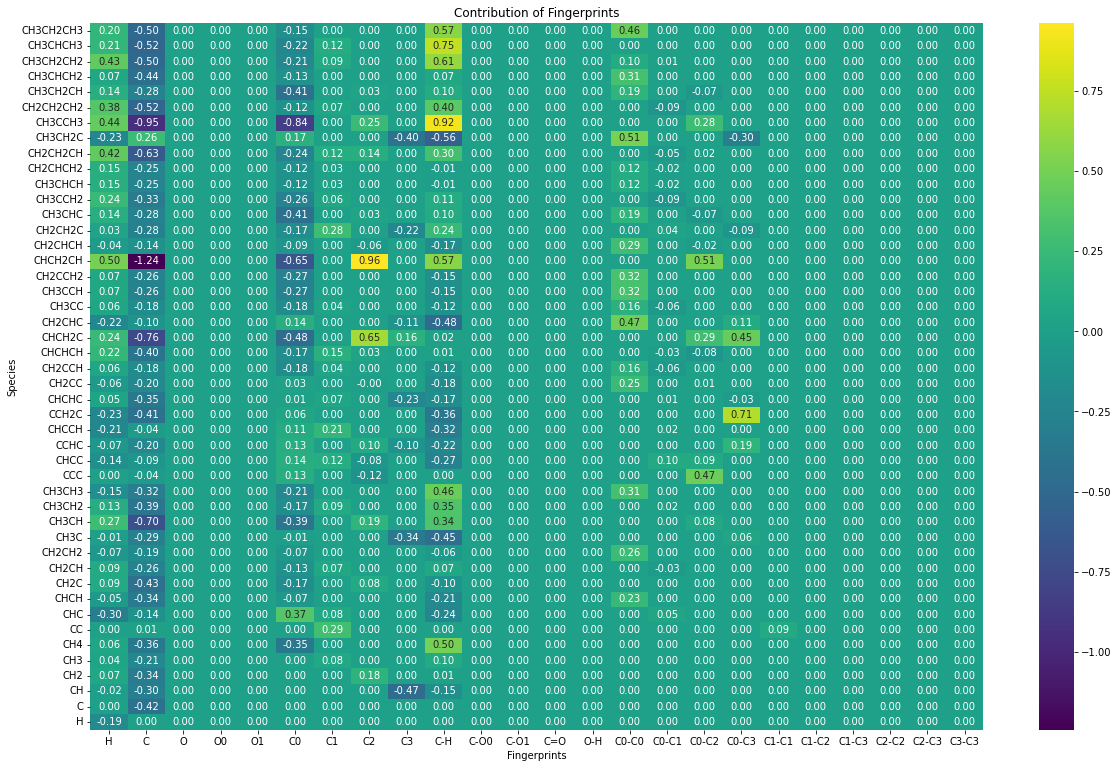

In [16]:
# 4. Visualize with Heatmap
feature_labels = [
    'H', 'C', 'O', 'O0', 'O1', 'C0', 
    'C1', 'C2', 'C3', 'C-H', 'C-O0', 'C-O1', 
    'C=O', 'O-H', 'C0-C0', 'C0-C1', 'C0-C2', 'C0-C3', 
    'C1-C1', 'C1-C2', 'C1-C3', 'C2-C2', 'C2-C3', 'C3-C3'
]
plt.figure(figsize=(20, 13))
# Create heatmap with annotations (values up to 2 decimal points) and row/column indices
sns.heatmap(
    final_attributions, cmap='viridis', cbar=True, annot=True, fmt=".2f",
    yticklabels=ylab, 
    xticklabels=feature_labels
)
plt.title("Contribution of Fingerprints")
plt.xlabel("Fingerprints")
plt.ylabel("Species")
plt.show()

In [17]:
# Compute the average absolute contribution of each of the 24 features
average_contribution = np.mean(np.abs(final_attributions), axis=0)
print(average_contribution, len(average_contribution))

[0.15259776 0.3370367  0.         0.         0.         0.18618785
 0.04434822 0.06352543 0.04425175 0.24109086 0.         0.
 0.         0.         0.10390673 0.01491475 0.04340132 0.04218724
 0.00205357 0.         0.         0.         0.         0.        ] 24


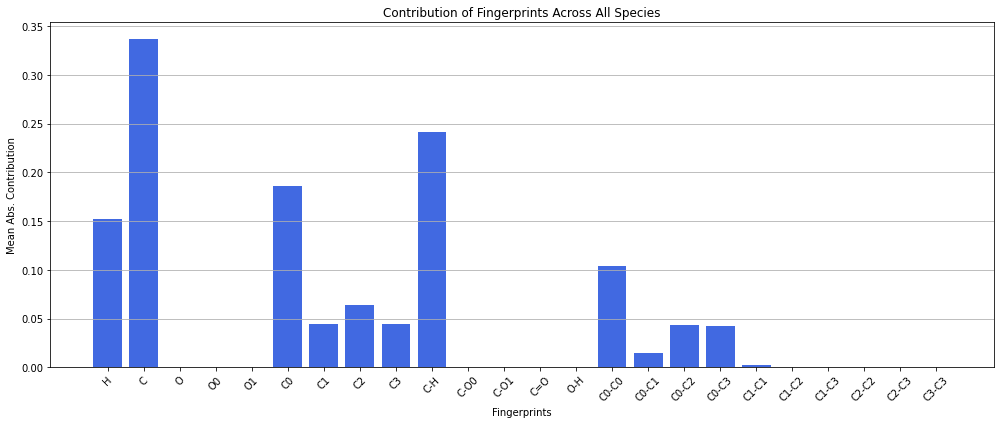

In [18]:
# Visualize the average contribution using a bar plot
plt.figure(figsize=(14, 6))
plt.bar(range(1, 25), average_contribution, color='royalblue', tick_label=feature_labels)
plt.xlabel("Fingerprints")
plt.ylabel("Mean Abs. Contribution")
plt.title("Contribution of Fingerprints Across All Species")
plt.xticks(rotation=45)  # Rotate labels to 90 degrees for better clarity
plt.grid(axis='y')

plt.tight_layout()  # Adjust layout to ensure all labels fit
plt.show()